# 1. ALNS for the Team Orienteering Problem with Time Windows

This notebook implements a full Adaptive Large Neighborhood Search (ALNS) algorithm to solve the Team Orienteering Problem with Time Windows (TOPTW). The goal is to maximize the total profit collected by a fleet of vehicles, minus the travel costs, while respecting time windows, and vehicle capacities.

We will follow this structure:
1.  **Setup:** Import libraries and define key parameters.
2.  **Data Structures:** Define the classes for the Problem (`TOPTWInstance`), Nodes (`TOPTWNode`), and Solution (`TOPTWRoute`).
3.  **Instance Loading:** Load a benchmark file and, crucially, add the **demand and capacity** data that turns it into a capacitated problem.
4.  **Core Functions (Validator & Objective):** Define the two most important functions:
    * `check_route_feasibility`: The "engine" that validates any given route.
    * `evaluate_solution`: The "goal" that tells us how good any solution is.
5.  **ALNS Step 1: Initial Solution:** Create a "good enough" starting solution.
6.  **ALNS Step 2: Operators (Ruin & Recreate):** Define the functions that will destroy and repair solutions.
7.  **ALNS Step 3: The Engine:** Define the main `alns` loop that orchestrates the entire process.
8.  **Execution & Results:** Set our hyperparameters, run the solver, and see the results.

## 2. Setup: Imports and Parameters

First, we import all necessary libraries and set the global parameters for our notebook, such as file paths and the number of vehicles to use.

In [22]:
# --- Core Python Libraries ---
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Dict, Union, Set
import math, re, pathlib, os, json, glob, random, copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- SET THE PARAMETERS ---
parameters = {
    "benchmark_directory": "../benchmarks/",
    "benchmark_file": "../benchmarks/50_c102.txt", # Example file
    "seed": 123,
    "K": 3,  # Number of vehicles that are available
}

## 3. Data Structures: Problem and Solution

We need to define *what* we are solving.
* `TOPTWNode`: Represents a single customer or the depot.
* `TOPTWInstance`: Represents the *entire problem* (all nodes, vehicle count `k`, capacity `Q`, etc.).
* `TOPTWRoute`: Represents a *single vehicle's route* in a potential solution. This class is crucial for performance, as it "caches" the properties of a route (its cost, profit, etc.).

In [23]:
from dataclasses import dataclass, field
from typing import List, Optional, Dict, Union, Set

# --- Problem Definition ---

@dataclass
class TOPTWNode:
    i: int
    x: float
    y: float
    service: float    # service duration
    profit: float     # profit / score
    tw_open: float    # earliest service time
    tw_close: float   # latest service time
    f: int            # extra field from original format
    a: int            # length of aux_list in original file
    aux_list: List[int]
    demand: int = 0   # NEW: demand of this node (0 for depot)

@dataclass
class TOPTWInstance:
    path: str
    k: int            # number of vehicles / routes allowed
    v: int            # carried over from source format
    N: int            # number of customers (excl. depot)
    t: int            # carried over from source format
    D: Optional[float]
    Q: Optional[float]   # vehicle capacity we'll assign
    Tmax: float          # usually depot.tw_close in source data
    nodes: List[TOPTWNode]

# --- Solution Definition ---

@dataclass
class TOPTWRoute:
    nodes: List[TOPTWNode] = field(default_factory=list) # sequence of nodes, depot at start/end
    load: float = 0.0           # total load of the route
    total_profit: float = 0.0   # total profit of the route
    total_cost: float = 0.0     # total cost (distance) of the route
    total_time: float = 0.0     # total time of the route
    
    def recalculate_properties(
        self,
        inst: TOPTWInstance,
        dist_matrix: List[List[float]],
        time_matrix: List[List[float]]
    ) -> bool:
        """
        Recalculates all properties (cost, time, profit, load)
        of this route based on its current 'self.nodes' list.
        Returns True if the route is feasible, False otherwise.
        """
        # We will define check_route_feasibility in the next cell
        props = check_route_feasibility(
            inst, dist_matrix, time_matrix, self.nodes
        )
        
        # Update self with the new properties
        self.load = props["total_load"]
        self.total_profit = props["total_profit"]
        self.total_cost = props["total_cost"]
        self.total_time = props["current_time"]
        
        return props["is_feasible"]

## 4. Instance Loading and Capacitation

This is a critical step. The TOPTW benchmarks you're using don't include **demand** or **vehicle capacity (`Q`)**. Your notebook includes helper functions to *add* this data, creating a capacitated instance. We will use these functions to load our problem.

This block contains all the helper functions for parsing the files.

In [24]:
def _floor_to_decimals(x: float, decimals: int) -> float:
    if decimals is None:
        return float(x)
    f = 10 ** decimals
    return math.floor(x * f) / f

def _auto_rounding_decimals_from_name(path: str) -> int:
    name = pathlib.Path(path).name.lower()
    if re.search(r'(?:^|_)((c|r|rc)\d+)', name):
        return 1
    return 2

def build_distance_time_matrices(inst: TOPTWInstance,
                                 speed: float = 1.0,
                                 rounding: str = "auto"
                                 ) -> Tuple[List[List[float]], List[List[float]]]:
    pts = [(n.x, n.y) for n in inst.nodes]
    n = len(pts)
    if rounding == "auto":
        dec = _auto_rounding_decimals_from_name(inst.path)
    elif rounding == "solomon":
        dec = 1
    elif rounding == "cordeau":
        dec = 2
    else:
        dec = None

    def euclid(a, b): return math.hypot(a[0]-b[0], a[1]-b[1])

    dist = [[0.0]*n for _ in range(n)]
    tmat = [[0.0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i == j:
                d = 0.0
            else:
                d = euclid(pts[i], pts[j])
                d = _floor_to_decimals(d, dec)
            dist[i][j] = d
            tmat[i][j] = d / speed if speed > 0 else d
    return dist, tmat

def parse_toptw_instance(path: str) -> TOPTWInstance:
    path = str(path)
    with open(path, "r", encoding="utf-8") as f:
        raw_lines = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith("*")]
    k, v, N, t = map(int, raw_lines[0].split())
    hdr2 = raw_lines[1].split()
    if len(hdr2) >= 2:
        D = float(hdr2[0]); Q = float(hdr2[1])
    elif len(hdr2) == 1:
        D = None; Q = float(hdr2[0])
    else:
        D = None; Q = None
    nodes: List[TOPTWNode] = []
    expected = N + 1
    lines = raw_lines[2:2+expected]
    for ln in lines:
        toks = ln.split()
        i = int(toks[0])
        x = float(toks[1]); y = float(toks[2])
        d = float(toks[3]); S = float(toks[4])
        f_val = int(float(toks[5])); a = int(float(toks[6]))
        pos_after_list = 7 + a
        if len(toks) >= pos_after_list + 2:
            aux = [int(float(t)) for t in toks[7:7+a]] if a > 0 else []
            O = float(toks[pos_after_list]); C = float(toks[pos_after_list + 1])
        else:
            O = float(toks[-2]); C = float(toks[-1])
            aux = [int(float(t)) for t in toks[7:-2]] if len(toks) > 9 else []
        nodes.append(TOPTWNode(i=i, x=x, y=y, service=d, profit=S,
                               tw_open=O, tw_close=C, f=f_val, a=a, aux_list=aux))
    Tmax = nodes[0].tw_close
    return TOPTWInstance(path=path, k=k, v=v, N=N, t=t, D=D, Q=Q, Tmax=Tmax, nodes=nodes)

def generate_demands(
    inst: TOPTWInstance,
    mode: str = "independent",
    rng: np.random.Generator | None = None,
    demand_range: Tuple[int, int] = (1,10)
) -> List[int]:
    lo, hi = demand_range
    n_total = inst.N + 1
    if rng is None:
        rng = np.random.default_rng()
    demands = [0]*n_total
    if inst.N == 0:
        return demands
    if mode == "independent":
        demands[1:] = rng.integers(lo, hi+1, size=inst.N).tolist()
    else:
        raise ValueError(f"Unknown mode: {mode}")
    return demands

def choose_capacity(demands: List[int], K: int, Q_ratio: float = 0.25) -> int:
    total_demand = sum(demands[1:])
    if total_demand <= 0: return 0
    target_combined = Q_ratio * total_demand
    if target_combined < 1: target_combined = 1
    if K > 0: Q = math.floor(target_combined / K)
    else: Q = math.floor(target_combined)
    if Q < 1: Q = 1
    max_single = max(demands[1:]) if len(demands) > 1 else 0
    if Q < max_single: Q = max_single
    return int(Q)

def load_capacitated_instance(
    file_path: str, 
    K: int, 
    seed: int
) -> Tuple[TOPTWInstance, List[List[float]], List[List[float]]]:
    """
    Loads a single TOPTW instance and adds demands and capacity.
    """
    inst = parse_toptw_instance(file_path)
    
    # Generate demands for all nodes
    rng = np.random.default_rng(seed)
    demands = generate_demands(inst, mode="independent", rng=rng, demand_range=(1, 10))
    
    # Assign demands to the nodes in the instance
    for node, d in zip(inst.nodes, demands):
        node.demand = d
        
    # Choose a vehicle capacity based on demands
    inst.k = K # Override instance's K with our parameter
    inst.Q = choose_capacity(demands, K=inst.k, Q_ratio=0.25)
    
    # Build distance/time matrices
    dist_matrix, time_matrix = build_distance_time_matrices(inst, rounding="auto")
    
    return inst, dist_matrix, time_matrix

Now, let's actually load our instance. `inst_cap` will be the problem we solve.

Successfully loaded and capacitated instance: ../benchmarks/50_c102.txt
Num Vehicles (K): 3
Vehicle Capacity (Q): 21
Num Customers (N): 50
Max Route Time (Tmax): 1236.0


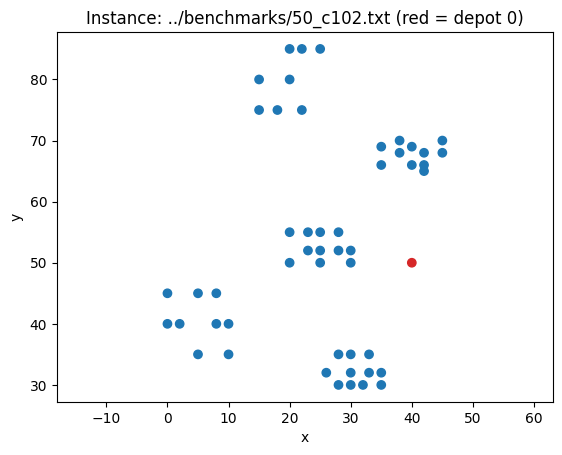

In [25]:
# --- Load the Capacitated Instance ---

PATH_TO_FILE = parameters["benchmark_file"]

if os.path.exists(PATH_TO_FILE):
    inst_cap, dist_matrix, time_matrix = load_capacitated_instance(
        file_path=PATH_TO_FILE,
        K=parameters["K"],
        seed=parameters["seed"]
    )
    print(f"Successfully loaded and capacitated instance: {inst_cap.path}")
    print(f"Num Vehicles (K): {inst_cap.k}")
    print(f"Vehicle Capacity (Q): {inst_cap.Q}")
    print(f"Num Customers (N): {inst_cap.N}")
    print(f"Max Route Time (Tmax): {inst_cap.Tmax}")
    
    # Plot the instance
    xs = [n.x for n in inst_cap.nodes]
    ys = [n.y for n in inst_cap.nodes]
    colors = ["tab:red" if n.i==0 else "tab:blue" for n in inst_cap.nodes]
    plt.figure()
    plt.scatter(xs, ys, c=colors)
    plt.title(f"Instance: {inst_cap.path} (red = depot 0)")
    plt.xlabel("x"); plt.ylabel("y")
    plt.axis("equal")
    plt.show()

else:
    print(f"Error: Benchmark file not found at {PATH_TO_FILE}")
    print("Please check the 'benchmark_file' path in the first code cell.")
    # Create dummy variables so the notebook doesn't crash
    inst_cap, dist_matrix, time_matrix = None, [], []


## 5. Core Functions: Validator and Objective

This section contains the two most important functions in the solver.

1.  **`check_route_feasibility`**: The "Validator." This function is the heart of the solver. It simulates a single route and checks it against all constraints: time windows, capacity, and max route time.
2.  **`evaluate_solution`**: The "Objective." This function defines our goal. It takes a *full solution* (a list of routes) and returns a single score that we want to *maximize*. Your definition is `Profit - (alpha * Distance)`.

In [26]:
def check_route_feasibility(
    inst: TOPTWInstance,
    dist_matrix: List[List[float]],
    time_matrix: List[List[float]],
    nodes_list: List[TOPTWNode]
) -> Dict[str, Union[float, bool]]:
    """
    Checks a single route (list of TOPTWNode objects) for feasibility.
    
    Returns a dictionary with keys:
    "is_feasible", "total_cost", "current_time", "total_load", "total_profit"
    """
    res: Dict[str, Union[float, bool]] = {
        "is_feasible": False,
        "total_load": 0.0,
        "total_profit": 0.0,
        "total_cost": 0.0,
        "current_time": 0.0
    }
    
    # A route must at least be [depot, depot]
    if len(nodes_list) < 2:
        return res
        
    for i in range(len(nodes_list) - 1):
        prev_node = nodes_list[i]
        curr_node = nodes_list[i+1]
        
        # 1. Add travel time and cost
        res["current_time"] += time_matrix[prev_node.i][curr_node.i]
        res["total_cost"] += dist_matrix[prev_node.i][curr_node.i]
        
        # 2. Check Time Window at arrival
        res["current_time"] = max(res["current_time"], curr_node.tw_open)
        
        if res["current_time"] > curr_node.tw_close:
            return res # Arrived too late
            
        # 3. Add service time
        res["current_time"] += curr_node.service
        
        # 4. Add demand and profit (only for customers)
        if curr_node.i != 0:
            res["total_load"] += curr_node.demand
            res["total_profit"] += curr_node.profit
            
    # 5. Check vehicle capacity (if Q is defined)
    if inst.Q is not None and res["total_load"] > inst.Q:
        return res
        
    # 6. Final Tmax check is implicitly handled by the depot's tw_close
    res["is_feasible"] = True
    return res

def evaluate_solution(
    routes: List[TOPTWRoute],
    alpha: float = 0.1,  # Weight for distance cost
    f: float = 0.0,      # Fixed cost per vehicle
    beta: float = 0.0    # Lateness penalty (for soft TW)
) -> float:
    """
    Returns the objective value (to be maximised):
        Σ profit – α * Σ distance – f * #vehicles – β * Σ lateness
    """
    total_profit = sum(r.total_profit for r in routes)
    total_dist   = sum(r.total_cost for r in routes)
    n_veh        = len(routes)
    
    # We assume hard time windows (lateness = 0), as per your
    # feasibility checker.
    lateness     = 0.0 

    return total_profit - alpha * total_dist - f * n_veh - beta * lateness

## 6. ALNS Step 1: Initial Solution

The ALNS algorithm needs a starting point. This function builds a "good enough" feasible solution using a **greedy** heuristic:
1.  Find the unvisited customer with the *best* profit-to-time-density.
2.  Find the *cheapest* feasible place to insert them in any route.
3.  Repeat.

In [27]:
def create_initial_solution(
    inst: TOPTWInstance,
    dist_matrix: List[List[float]],
    time_matrix: List[List[float]]
) -> List[TOPTWRoute]:
    """
    Creates a greedy initial solution based on profit density.
    Returns a list of TOPTWRoute objects.
    """
    
    # --- Create a helper map to look up nodes by their index ---
    node_map = {n.i: n for n in inst.nodes}
    
    # 1. --- Initialization ---
    depot_node = inst.nodes[0]
    routes: List[TOPTWRoute] = []
    for _ in range(inst.k):
        routes.append(TOPTWRoute(nodes=[depot_node, depot_node]))

    # --- FIX: Create a set of hashable node INDICES ---
    unvisited_indices: Set[int] = set(n.i for n in inst.nodes[1:]) # e.g., {1, 2, 3, ...}

    # 2. --- Density Helper Function ---
    def density(node_idx: int) -> float:
        """Calculates profit density for a customer node index."""
        node = node_map[node_idx] # Get the node object from the map
        t0_i = time_matrix[0][node.i]
        return node.profit / (t0_i + node.service + 1e-9)

    # 3. --- Main Loop ---
    while unvisited_indices:
        
        # 4. --- Candidate Selection ---
        # --- FIX: Find the best index from the set of indices ---
        best_c_idx = max(unvisited_indices, key=density, default=None)
        if best_c_idx is None:
            break
            
        best_c_node = node_map[best_c_idx] # Get the corresponding node object

        # 5. --- Find Best Insertion Position ---
        best_insertion_cost = float('inf')
        best_route_idx = -1
        best_pos = -1
        
        best_route_props: dict[str, float|bool] = {} 

        for r_idx, route in enumerate(routes):
            current_cost = route.total_cost 
            
            for pos in range(1, len(route.nodes)):
                
                # a) Create hypothetical route (this is fine, uses the node object)
                new_node_list = (
                    route.nodes[:pos] + [best_c_node] + route.nodes[pos:]
                )
                
                # b) Check feasibility
                new_route_props = check_route_feasibility(
                                      inst, dist_matrix, time_matrix, new_node_list
                                  )

                if not new_route_props["is_feasible"]:
                    continue

                # c) Calculate insertion cost
                insertion_cost = new_route_props["total_cost"] - current_cost

                # d) Check if this is the best insertion
                if insertion_cost < best_insertion_cost:
                    best_insertion_cost = insertion_cost
                    best_route_idx = r_idx
                    best_pos = pos
                    best_route_props = new_route_props 

        # 6. --- Perform Insertion ---
        if best_route_idx == -1:
            # --- FIX: Remove the index from the set ---
            unvisited_indices.remove(best_c_idx)
            continue

        # Update the route object IN-PLACE
        r = routes[best_route_idx]
        
        r.nodes.insert(best_pos, best_c_node)
        r.load = best_route_props["total_load"]
        r.total_profit = best_route_props["total_profit"]
        r.total_cost = best_route_props["total_cost"]
        r.total_time = best_route_props["current_time"]
        
        # --- FIX: Remove the inserted index from the set ---
        unvisited_indices.remove(best_c_idx)

    # 7. --- Final Cleanup ---
    final_routes = [r for r in routes if len(r.nodes) > 2]
    
    return final_routes

## 7. ALNS Step 2: Ruin and Recreate Operators

This is the core of ALNS. We define operators to "ruin" (destroy) part of a solution and "recreate" (repair) it.

* **Ruin Operators:**
    * `random_removal`: Removes `p%` of customers at random.
    * `shaw_removal`: Removes customers that are "related" (e.g., close to each other).
* **Recreate Operator:**
    * `repair_greedy`: Tries to re-insert the removed customers using the same greedy logic as the initial solution.

In [28]:
import random
from typing import List, Set, Dict, Union # Ensure all imports are here

def flatten_routes(solution: List[TOPTWRoute]) -> List[TOPTWNode]:
    """
    Gets a single list of all CUSTOMER nodes in the solution.
    """
    seq: List[TOPTWNode] = []
    for r in solution:
        seq.extend(r.nodes[1:-1])  # Skip depot at [0] and [-1]
    return seq

def remove_customers(
    inst: TOPTWInstance,
    solution: List[TOPTWRoute],
    to_remove: List[TOPTWNode],
    dist_matrix: List[List[float]],
    time_matrix: List[List[float]]
):
    """
    Removes a list of customer nodes from the solution IN-PLACE.
    It updates the routes' properties after removal.
    """
    # Create a set of node indices for fast lookup
    to_remove_indices = {n.i for n in to_remove}

    for route in solution:
        # Re-build the nodes list, keeping only those NOT in the removal set
        # (or the depot, which has index 0)
        original_nodes = route.nodes
        route.nodes = [n for n in original_nodes 
                       if (n.i not in to_remove_indices) or (n.i == 0)]

        # If the route changed, recalculate its properties
        if len(route.nodes) < len(original_nodes):
            
            # Collapse [depot, depot] if all customers were removed
            if len(route.nodes) < 3:
                depot_node = inst.nodes[0]
                route.nodes = [depot_node, depot_node]
            
            # Recalculate cost, time, etc.
            route.recalculate_properties(inst, dist_matrix, time_matrix)
            
    # Note: This function modifies 'solution' in-place and returns nothing.


def random_removal(
    inst: TOPTWInstance,
    solution: List[TOPTWRoute],
    rng: random.Random,
    dist_matrix: List[List[float]],
    time_matrix: List[List[float]],
    p: float = 0.2
) -> List[TOPTWNode]:
    """
    Removes p% of customers from the solution randomly.
    Modifies the solution in-place.
    Returns the list of TOPTWNode objects that were removed.
    """
    all_customers = flatten_routes(solution)
    if not all_customers:
        return []

    # Calculate number of customers to remove
    k = max(1, int(len(all_customers) * p))
    picked_nodes = rng.sample(all_customers, k)
    
    # Remove them from the solution
    remove_customers(inst, solution, picked_nodes, dist_matrix, time_matrix)
    
    return picked_nodes

def shaw_removal(
    inst: TOPTWInstance,
    solution: List[TOPTWRoute],
    rng: random.Random,
    dist_matrix: List[List[float]],
    time_matrix: List[List[float]],
    p: float = 0.2
) -> List[TOPTWNode]:
    """
    Removes p% of customers based on "relatedness" (Shaw Removal).
    Modifies the solution in-place.
    Returns the list of TOPTWNode objects that were removed.
    """
    all_customers = flatten_routes(solution) # List[TOPTWNode]
    if not all_customers:
        return []

    # --- FIX: Create a node map and use indices ---
    node_map = {n.i: n for n in inst.nodes} # Map index -> object
    all_customer_indices = [n.i for n in all_customers]
    
    seed_idx = rng.choice(all_customer_indices)
    
    # Use distance from the pre-computed matrix (operates on indices)
    def relatedness(idx1: int, idx2: int):
        return dist_matrix[idx1][idx2]

    rem_list_indices = [seed_idx]
    cand_pool_indices = set(all_customer_indices) - {seed_idx} # Set of indices
    
    target_k = max(1, int(len(all_customers) * p))
    
    while len(rem_list_indices) < target_k and cand_pool_indices:
        best_j_idx = None
        best_score = float('inf')
        
        # Find candidate 'j' closest to any node 'i' already in the removal list
        for j_idx in list(cand_pool_indices):
            score = min(relatedness(i_idx, j_idx) for i_idx in rem_list_indices)
            
            if score < best_score:
                best_score = score
                best_j_idx = j_idx
        
        if best_j_idx is not None:
            rem_list_indices.append(best_j_idx)
            cand_pool_indices.remove(best_j_idx)
        else:
            break # Should not happen if cand_pool is not empty
            
    # --- FIX: Convert indices back to node objects for remove_customers ---
    rem_list_nodes = [node_map[i] for i in rem_list_indices]
            
    remove_customers(inst, solution, rem_list_nodes, dist_matrix, time_matrix)
    return rem_list_nodes

def repair_greedy(
    inst: TOPTWInstance,
    solution: List[TOPTWRoute],
    missing_customers: List[TOPTWNode],
    rng: random.Random,
    dist_matrix: List[List[float]],
    time_matrix: List[List[float]]
) -> List[TOPTWNode]:
    """
    Tries to re-insert all missing_customers into the solution
    using a greedy "best-cost" insertion.
    
    Modifies 'solution' in-place.
    
    Returns a list of TOPTWNode objects that could NOT be re-inserted.
    """
    
    unserved = list(missing_customers) # This is List[TOPTWNode]
    rng.shuffle(unserved) # Randomize insertion order
    
    failed_to_insert: List[TOPTWNode] = []
    
    for c_node in unserved:
        
        # --- Find Best Insertion Position ---
        best_insertion_cost = float('inf')
        best_route_idx = -1
        best_pos = -1
        best_route_props: Dict[str, Union[float, bool]] = {}

        for r_idx, route in enumerate(solution):
            current_cost = route.total_cost 
            
            for pos in range(1, len(route.nodes)):
                
                # a) Create hypothetical route
                new_node_list = (
                    route.nodes[:pos] + [c_node] + route.nodes[pos:]
                )
                
                # b) Check feasibility
                new_route_props = check_route_feasibility(
                                      inst, dist_matrix, time_matrix, new_node_list
                                  )

                if not new_route_props["is_feasible"]:
                    continue

                # c) Calculate insertion cost
                insertion_cost = new_route_props["total_cost"] - current_cost

                # d) Check if this is the best insertion
                if insertion_cost < best_insertion_cost:
                    best_insertion_cost = insertion_cost
                    best_route_idx = r_idx
                    best_pos = pos
                    best_route_props = new_route_props

        # --- Perform Insertion (or not) ---
        if best_route_idx == -1:
            # **CRITICAL TOPTW CHANGE**
            # Could not find a feasible spot.
            # DO NOT create a new route.
            # Add this customer to the failed list.
            failed_to_insert.append(c_node)
        else:
            # Found a valid spot! Insert the customer.
            r = solution[best_route_idx]
            
            r.nodes.insert(best_pos, c_node)
            r.load = best_route_props["total_load"]
            r.total_profit = best_route_props["total_profit"]
            r.total_cost = best_route_props["total_cost"]
            r.total_time = best_route_props["current_time"]

    return failed_to_insert

## 8. ALNS Step 3: The Engine

This is the main `alns` function that orchestrates the entire process. It's the code you provided, but fixed and adapted for our problem.

In [ ]:
def accept_metropolis_maximization(
    old_objective: float, 
    new_objective: float, 
    T: float, 
    rng: random.Random
) -> bool:
    """
    Metropolis acceptance criterion for a MAXIMIZATION problem.
    """
    if new_objective >= old_objective:
        return True # Always accept better solutions
    
    # Accept worse solutions with a probability
    delta = old_objective - new_objective # How much worse it is
    prob = math.exp(-delta / max(T, 1e-9))
    return (rng.random() < prob)

def weighted_choice(rng: random.Random, probs: List[float]) -> int:
    """Picks an index i with probability probs[i]"""
    s = sum(probs)
    if s <= 0:
        return rng.randrange(len(probs))
    r = rng.random() * s
    acc = 0.0
    for i, p in enumerate(probs):
        acc += p
        if r <= acc:
            return i
    return len(probs) - 1

def alns(
    inst: TOPTWInstance,
    dist_matrix: List[List[float]],
    time_matrix: List[List[float]],
    iters: int,
    p_remove: float,
    T0: float,
    cooling: float,
    seed: int,
    alpha_smooth: float, # 'alpha' from your notebook
    segment_length: int,
    alpha_obj: float = 0.1, # 'alpha' from evaluate_solution
    f_obj: float = 0.0,
    beta_obj: float = 0.0
):
    
    rng = random.Random(seed)

    # --- Operator Pool ---
    # We use lambda to adapt our functions to the signature
    # the ALNS loop expects (it just passes solution and rng)
    destroy_ops = [
        ("random", lambda sol, rng: random_removal(
            inst, sol, rng, dist_matrix, time_matrix, p=p_remove)),
        ("shaw", lambda sol, rng: shaw_removal(
            inst, sol, rng, dist_matrix, time_matrix, p=p_remove)),
    ]
    n_ops = len(destroy_ops)
    weights = [1.0] * n_ops
    probs   = [1.0/n_ops] * n_ops
    seg_score = [0.0] * n_ops
    seg_used  = [0] * n_ops

    # --- Initial Solution ---
    curr = create_initial_solution(inst, dist_matrix, time_matrix)
    curr_objective = evaluate_solution(curr, alpha_obj, f_obj, beta_obj)
    
    # We MUST use deepcopy to create independent snapshots
    best = copy.deepcopy(curr)
    best_objective = curr_objective

    hist_best_objective = [best_objective]
    T = T0
    iter_log: list[dict] = []

    for it in range(iters):
        # Choose destroy operator
        op_id = weighted_choice(rng, probs)
        op_name, op_fun = destroy_ops[op_id]

        # --- Destroy + Repair ---
        # MUST deepcopy. 'cand' will be modified in-place by the operators
        cand = copy.deepcopy(curr)
        removed_nodes = op_fun(cand, rng)
        
        # repair_greedy also modifies 'cand' in-place
        unserved_nodes = repair_greedy(
            inst, cand, removed_nodes, rng, dist_matrix, time_matrix
        )

        accepted = False
        reward   = 0.0
        note     = ""

        cand_objective = evaluate_solution(cand, alpha_obj, f_obj, beta_obj)

        if accept_metropolis_maximization(curr_objective, cand_objective, T, rng):
            accepted = True

            # Reward logic is FLIPPED for maximization (higher is better)
            if cand_objective > best_objective + 1e-9:
                reward = 5.0
                note = "new_global_best"
            elif cand_objective > curr_objective + 1e-9:
                reward = 2.0
                note = "improved_curr"
            else:
                reward = 0.5
                note = "accepted_worse"

            # Update current solution
            curr, curr_objective = cand, cand_objective # No copy needed here

            # Maybe update best
            if cand_objective > best_objective + 1e-9:
                best, best_objective = copy.deepcopy(cand), cand_objective
        else:
            reward = 0.0
            note = "rejected"

        seg_score[op_id] += reward
        seg_used[op_id]  += 1

        iter_log.append({
            "iter": it, "T": T, "op_name": op_name, "accepted": accepted,
            "reward": reward, "note": note, "curr_obj": curr_objective,
            "best_obj": best_objective,
        })

        # Cooling
        hist_best_objective.append(best_objective)
        T *= cooling

        # Segment update
        if (it+1) % segment_length == 0:
            for j in range(n_ops):
                if seg_used[j] > 0:
                    avg_score = seg_score[j] / seg_used[j]
                else:
                    avg_score = 0.0
                weights[j] = alpha_smooth * weights[j] + (1.0-alpha_smooth) * avg_score

            s = sum(weights)
            if s <= 0:
                probs = [1.0/n_ops] * n_ops
            else:
                probs = [w/s for w in weights]

            seg_score = [0.0] * n_ops
            seg_used  = [0] * n_ops

    # return all diagnostics
    return {
        "best_solution": best,
        "best_objective": best_objective,
        "history": hist_best_objective,
        "iter_log": iter_log,
        "final_probs": probs,
    }

## 9. Execution and Results

Now we define our hyperparameters and run the solver. This new "Run" cell connects all the pieces.

In [34]:
# --- Set Hyperparameters ---
# (These are from your notebook, but I've matched the names)
hyperparameter_sets = [
    {
        "id": "Run_1",
        "iters": 1000,
        "p_remove": 0.2,
        "T0": 5000.0, # Initial temp
        "cooling": 0.995,
        "alpha_smooth": 0.8, # Weight smoothing
        "segment_length": 50,
        "seed": 42,
        "alpha_obj": 0.1, # Objective: distance weight
        "f_obj": 0.0,     # Objective: fixed cost per vehicle
        "beta_obj": 0.0   # Objective: lateness penalty
    }
]

# --- Store Results ---
results_history = {}
best_solutions = {}

# --- Run the Algorithm ---
if inst_cap:
    print(f"--- Running ALNS for {inst_cap.path} ---")
    
    for params in hyperparameter_sets:
        print(f"\nStarting {params['id']}...")
        
        run_results = alns(
            inst=inst_cap,
            dist_matrix=dist_matrix,
            time_matrix=time_matrix,
            iters=params["iters"],
            p_remove=params["p_remove"],
            T0=params["T0"],
            cooling=params["cooling"],
            seed=params["seed"],
            alpha_smooth=params["alpha_smooth"],
            segment_length=params["segment_length"],
            alpha_obj=params["alpha_obj"],
            f_obj=params["f_obj"],
            beta_obj=params["beta_obj"]
        )
        
        print(f"Finished {params['id']}.")
        print(f"  Best Objective: {run_results['best_objective']:.2f}")
        print(f"  Final Operator Probs: {run_results['final_probs']}")
        
        results_history[params['id']] = run_results["history"]
        best_solutions[params['id']] = run_results["best_solution"]

else:
    print("Cannot run algorithm: inst_cap was not loaded.")


--- Running ALNS for ../benchmarks/50_c102.txt ---

Starting Run_1...
Finished Run_1.
  Best Objective: 400.43
  Final Operator Probs: [0.5319021175466258, 0.4680978824533743]


Finally, let's plot the "convergence" of the objective score. This shows us if the algorithm is successfully improving the solution over time.

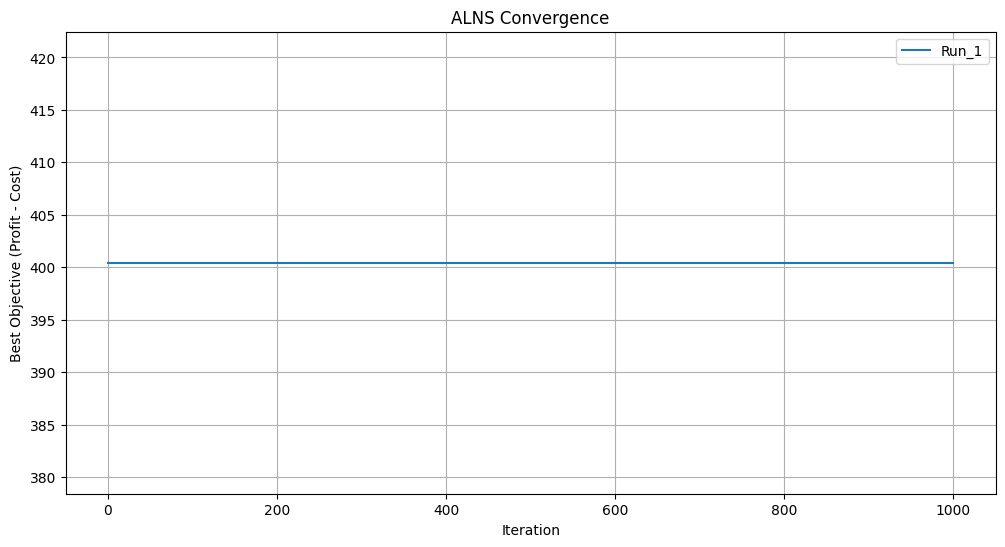


--- Best Solution (Run_1) ---
Total Objective: 400.43
Found 3 routes:
  Route 1 (Profit: 200.00, Cost: 146.10, Load: 21/21):
    0 -> 33 -> 25 -> 8 -> 15 -> 16 -> 6 -> 0
  Route 2 (Profit: 120.00, Cost: 117.10, Load: 21/21):
    0 -> 13 -> 2 -> 7 -> 46 -> 47 -> 0
  Route 3 (Profit: 120.00, Cost: 132.50, Load: 21/21):
    0 -> 32 -> 42 -> 31 -> 38 -> 21 -> 0


In [35]:
# --- Plot Results ---
plt.figure(figsize=(12, 6))
for run_id, history in results_history.items():
    plt.plot(history, label=run_id)

plt.title("ALNS Convergence")
plt.xlabel("Iteration")
plt.ylabel("Best Objective (Profit - Cost)")
plt.legend()
plt.grid(True)
plt.show()

# --- Print Best Solution Found ---
if best_solutions:
    # Find the best run ID based on the final objective
    best_run_id = max(results_history, key=lambda k: results_history[k][-1])
    best_sol_routes = best_solutions[best_run_id]
    
    print(f"\n--- Best Solution ({best_run_id}) ---")
    print(f"Total Objective: {results_history[best_run_id][-1]:.2f}")
    print(f"Found {len(best_sol_routes)} routes:")
    
    for i, route in enumerate(best_sol_routes):
        route_nodes_str = " -> ".join([str(n.i) for n in route.nodes])
        print(f"  Route {i+1} (Profit: {route.total_profit:.2f}, Cost: {route.total_cost:.2f}, Load: {route.load:.0f}/{inst_cap.Q}):")
        print(f"    {route_nodes_str}")
